# MNIST Classification

In this notebook, we'll explore the MNIST (Modified National Institute of Standards and Technology) database - a large set of handwritten digits with their associated labels.  A common Machine Learning challenge is to build a multiclass classifier than can tell with high accuracy what digit a given image represents.

In [1]:
# Import modules for maths, data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('default')

In [2]:
# Fetch and load data
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
# Extract features and labels
data, labels = mnist["data"], mnist["target"].astype(np.uint8)

# Select three arbitrary digits
example_digits = data[40:43]

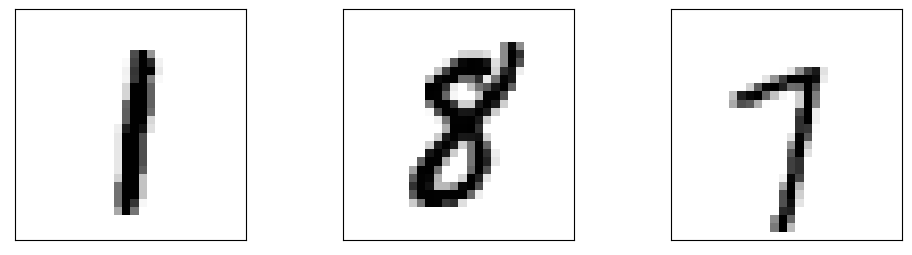

In [4]:
# Set up plotting area
fig = plt.figure(figsize=(12,3))

# Set up subplots for each digit - we'll plot each one side by side to illustrate the variation
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
axs = [ax1, ax2, ax3]

# Plot the digits
for i in range(3):
    
    ax = axs[i]
    ax.imshow(example_digits[i].reshape(28, 28), cmap="binary")
    ax.set_xticks([], []) 
    ax.set_yticks([], []) 

plt.show()

Before going any further, let's split the data into training and test sets.  Then we can explore the training set all we like without risking becoming biased and giving ourselves an unfair advantage when we eventually come to evaluate the performance of our model on the test set.

In [5]:
data_train, data_test, labels_train, labels_test = data[:60000], data[60000:], labels[:60000], labels[60000:]

## Simplify the problem - Binary Classifier

As a first step, let's simplify the classification problem and build a binary classifier.  Let's see if we can train a model to recognise 7's.  The two possible outcomes for this scenario are then simply *7* and *not 7*.

In [6]:
labels_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [7]:
labels_train_7 = (labels_train == 7) # True for 7's, false for all other digits
labels_test_7 = (labels_test == 7)

Now let's select and train a classifier.  A good place to start is with a *Stochastic Gradient Descent* (SGD) classifier as they can handle large datasets efficiently.

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf_7 = SGDClassifier(random_state=0) # Instantiate model
sgd_clf_7.fit(data_train, labels_train_7) # Train to recognise 7's

SGDClassifier(random_state=0)

Evaluate the model on our three example digits from earlier:

In [9]:
sgd_clf_7.predict(example_digits)

array([False, False,  True])

How delightful - our classifier has got it right.  Now, let's see how it does when we cross-validate the model:

In [10]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf_7, data_train, labels_train_7, cv=3, scoring="accuracy")

array([0.9754 , 0.9795 , 0.98115])

Not too shabby!  Our classifer scores at least 96% accuracy in distinguishing sevens from not-sevens.  But wait - is this really so impressive?  Let's construct the stupidest model we can - one that always guesses that the digit isn't a seven.  There are a lot of not-sevens in the dataset, so it might end up doing quite well despite its lack of intelligence.

In [11]:
from sklearn.base import BaseEstimator

class AlwaysNot7(BaseEstimator):
    
    def fit(self, X, y=None):
        return self # Fitting does nothing
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool) # Return an array made up of one False per instance of data

always_not_7_clf = AlwaysNot7()

cross_val_score(always_not_7_clf, data_train, labels_train_7, cv=3, scoring="accuracy")

array([0.89535, 0.8984 , 0.893  ])

Our dumb model scores 89% accuracy!  We're still significantly more accurate when we actually train our model, but this exercise just shows that model performance is relative and needs to be compared to a suitable baseline to properly evaluate it.

Now, instead of just coming up with the cross validation accuracy scores, let's actually get a set of predictions.  We can use cross_val_predict to get a "clean" set of predictions on the training data - ie predictions for each instance in the training data are obtained by training the model on a set of folds *which do not contain the instance being predicted.*  In this way, we ensure that the model can't cheat by seeing the answer before making a prediction!

In [12]:
from sklearn.model_selection import cross_val_predict

data_train_predictions = cross_val_predict(sgd_clf_7, data_train, labels_train_7, cv=3)

In [13]:
from sklearn.metrics import confusion_matrix

conf_mx_7 = confusion_matrix(labels_train_7, data_train_predictions)
conf_mx_7

array([[53321,   414],
       [  865,  5400]], dtype=int64)

We get the following results:
- 53,321 True Positives (model predicted 7, was actually a 7);
- 414 False Negatives (model predicted not-7, was actually a 7);
- 865 False Positives (model predicted 7, was actually not a 7); and
- 5400 True Negatives (model predicted not-7, was actually not a 7).

## Precision and Recall

*Precision* is the ratio of True Positives to positive predictions, ie TP / (TP + FP).  Precision represents how reliable the model's positive predictions are.  

*Recall* is the ratio of True Positives to all positive instances in the dataset, ie TP / (TP + FN).  Recall represents how good the model is at catching positive instances.  

The mathematics of calculating precision and recall is not particularly demanding for this example, but nonetheless, they can easily be calculated as follows:

In [14]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(labels_train_7, data_train_predictions))
print(recall_score(labels_train_7, data_train_predictions))

0.9287925696594427
0.8619313647246608


Our model thus has around 93% precision and 86% recall.  The precision and recall are often combined into a single metric for convenience—the F1 score.  It's calculated as the harmonic mean of the precision and recall (this means that we will only get a high F1 score if both the precision and recall are high.  If either one is low, then it will drag the average down significantly).

In [15]:
from sklearn.metrics import f1_score

print(f1_score(labels_train_7, data_train_predictions))

0.8941137511383392


As both our precision and recall are pretty high, the F1 score is also quite good.  On the whole, our model isn't half bad at identifying sevens.  Perhaps it would struggle with more ambiguous numbers, though—the only digit that is vagualy similar to 7 is 1.  

Our SGD classifier makes decisions by calculating a *decision score* for each instance.  If the decision score for a given instance is above a particular value, then that instance is predicted to be a positive result—otherwise it is classified as negative.  If we were able to increase the threshold, then the model would give more negative predictions and would only give predictions for the instances that it was more sure about (which would have higher decision scores).

We cannot set the threshold of our SGD classifier directly, but we can access the decision scores that the model produces for a given set of data.  We can then set our own threshold, compare it with the decision scores, and infer what the model would have throught if it had used that threshold.  We can get decision scores using cross_val_predict with the method parameter set to "decision_function".

In [16]:
data_train_decision_scores = cross_val_predict(sgd_clf_7, data_train, labels_train_7, cv=3,
                                                method="decision_function")

In [17]:
threshold = 0

print(sum(data_train_decision_scores > threshold))

threshold = 1000 # Require model to be more confident to classify as positive by raising decision score threshold

print(sum(data_train_decision_scores > threshold))

5814
5542


Raising the threshold reduces the number of positive predictions.  However, this will typically mean that there are now more false negatives—positive instances that the model would have correctly identified if it was allowed to be less prudent with its estimates.  

We can plot how the precision and recall vary with the threshold.  By doing this, we can select a threshold that gives us an acceptable balance of precision and recall.  Whether we require high precision, high recall, or indeed both, depends on the particular situation in which the model will be applied.  In some circumstances, high recall may be preferred over high precision if there is little cost associated with a few false alarms (false positives) but high costs associated with missing a positive instance (false negatives).

In [19]:
data_train_decision_scores

array([-31442.28649015, -27728.949546  , -22161.20000825, ...,
       -43950.58997604, -28967.61302175, -25061.53727363])

In [21]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(labels_train_7, data_train_decision_scores)

In [22]:
precisions

array([0.12774504, 0.12772725, 0.12772986, ..., 1.        , 1.        ,
       1.        ])

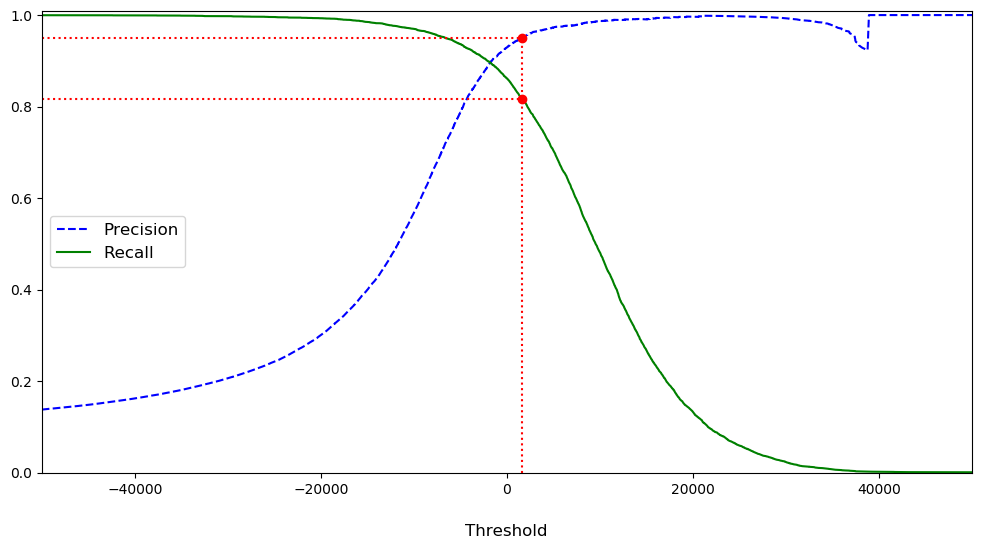

In [36]:
# Set up plotting area
fig, ax = plt.subplots(figsize=(12,6))

# Plot decision and recall curves
ax.plot(thresholds, precisions[:-1], "b--", label="Precision")
ax.plot(thresholds, recalls[:-1], "g-", label="Recall")

# Add legend to distinguish lines
ax.legend(loc="center left", fontsize=12)

# Set x axis label
ax.set_xlabel("Threshold", labelpad=20, fontsize=12)

# Set appropriate x- and y-axis limits
ax.axis([-50000,50000,0,1.01])


# What threshold should we set if we wanted 95% precision?  Use np.argmax()
# (precisions >= 0.95) is an array of [False, False, ..., False, True, True, ...]
# With the first True representing the lowest threshold for which precision in greater than 95%
# np.argmax() sees True as 1 and False as 0 so it takes the first instance of the maximum value in the array and
# returns the index position in the array.  We can use this index to find the corresponding threshold and recall.
threshold_95_precision = thresholds[np.argmax(precisions >= 0.95)]
recall_95_precision = recalls[np.argmax(precisions >= 0.95)]

# Plot this threshold and the associated precision and recall
ax.plot([threshold_95_precision, threshold_95_precision], [0.0, 0.95], "r:")
ax.plot([-50000, threshold_95_precision], [0.95, 0.95], "r:")
ax.plot([-50000, threshold_95_precision], [recall_95_precision, recall_95_precision], "r:")

ax.plot(threshold_95_precision, recall_95_precision, "ro")
ax.plot(threshold_95_precision, 0.95, "ro")

Remark that as the decision score threshold is increased, the number of true positives can only decrease.  Similarly, the number of false positives can only decrease.  However, the number of false negatives will increase.  

Because both true and false positives can decrease, it is possible for precision to decrease on a local scale as the threshold is increased - although the trend will generallly be positive.  This is why the pecision curve is bumpy.  Conversely, recall can only decrease as the threshold is increased, leading to a smooth curve.

The reason for the dip in precision at high thresholds is as follows: when the threshold is already high, the model will only predict positive for instances that it is very confident about, and there will be very few false positives—if the model has even a small doubt about a particular instance, it will class if as negative.  So the effect of increasing the threshold even higher begins to reduce true positives while having little effect on false positives.  This causes recall to fall rather continuously.

Another useful way of visualising the tradeoff between precision and recall is to simply plot them against eachother.

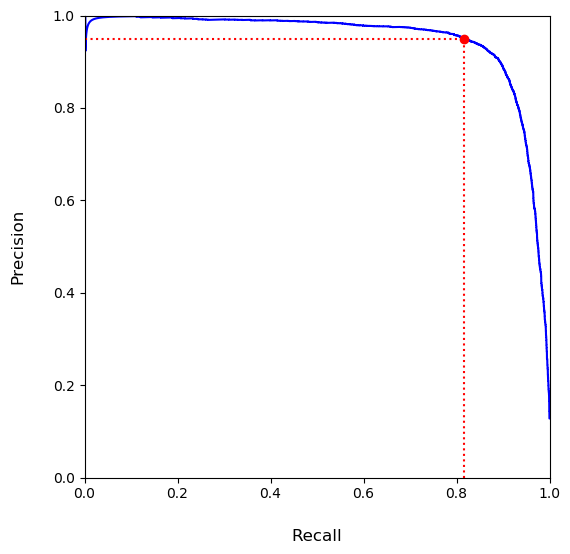

In [42]:
# Set up plotting area
fig, ax = plt.subplots(figsize=(6,6))

# Plot curve
ax.plot(recalls, precisions, "b-")

# Set x-axis label
ax.set_xlabel("Recall", labelpad=20, fontsize=12)

# Set y-axis label
ax.set_ylabel("Precision", labelpad=20, fontsize=12)

# Set appropriate x- and y-axis limits
ax.axis([0,1,0,1])

# Plot recall corresponding to 95% precision
ax.plot([recall_95_precision, recall_95_precision], [0, 0.95], "r:")
ax.plot([0, recall_95_precision], [0.95, 0.95], "r:")

ax.plot(recall_95_precision, 0.95, "ro")

We can observe that for this particular classifer, we can achieve a high precision without sacrificing much recall.  However, precision really starts to fall off sharply at around 90% recall - so we wouldn't want to try to increase recall further than that.  The same shape is true in general for precision/recall of classifiers - there will be a point where increasing recall begins to have a sharply noticeable detrimental effect on precision.  We would usually want to balance the two quantities at a point just before this drop off in the curve.

## ROC (Receiver Operating Characteristic) Curve

The ROC curve is another common tool for evaluating the performance of binary classifiers.  It takes the form of a plot of the true positive rate (TPR) against the false positive rate (FPR) as the decision score threshold is varied (for a given threshold, there is only one TPR and FPR).  We can use the roc_curve function from sklearn to easily compute the TPR and FPR for various thresholds.

For comparison, let's also train a Random Forest model and see how its ROC curve compares to that of our SGD model.

In [64]:
from sklearn.ensemble import RandomForestClassifier

rf_clf_7 = RandomForestClassifier(random_state=0)
data_train_rf_probabilities = cross_val_predict(rf_clf_7, data_train, labels_train_7, cv=3,
                                               method="predict_proba")

In [70]:
data_train_rf_decision_scores = data_train_rf_probabilities[:, 1]

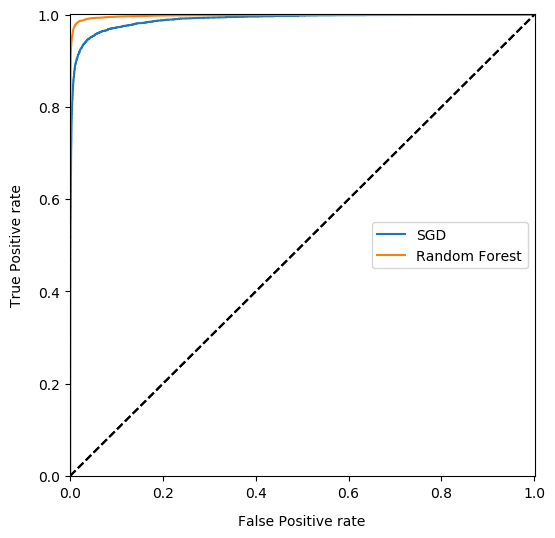

In [71]:
from sklearn.metrics import roc_curve

fpr_sgd, tpr_sgd, thresholds_sgd = roc_curve(labels_train_7, data_train_decision_scores)
fpr_rf, tpr_rf, thresholds_tree = roc_curve(labels_train_7, data_train_rf_decision_scores)

fig, ax = plt.subplots(figsize=(6,6))

def plot_roc_curve(fpr, tpr, label=None):
    ax.plot(fpr, tpr, label=label)
    ax.plot([0,1], [0,1], "k--") # Dashed diagonal line - random model
    
    ax.axis([-0.001,1.001,-0.001,1.001])
    ax.legend(loc="center right")
    ax.set_xlabel("False Positive rate", labelpad=10)
    ax.set_ylabel("True Positive rate", labelpad=10)

plot_roc_curve(fpr_sgd, tpr_sgd, "SGD")
plot_roc_curve(fpr_rf, tpr_rf, "Random Forest")

The ROC curve for a superior model is further towards the top left hand corner of the plot—that is, further away from the diagonal line across the middle, which represents a random model (that's just makes a guess rather than any kind of "prediction").  We can hence see that the Random Forest is superior to the SGD model in this example.

The AUC, or Area Under Curve, is simply that - the area under the ROC curve.  A perfect model will have an AUC of 1, a random model will have an AUc of 0.5, and a the perfect worse-than-random model will have an AUC of 0 (all predictions are precisely the wrong way round).


## Multiclass Classification

Some classifiers can handle multiple classes natively, such as SGD, Naive Bayes, and Random Forests.  Some other algorithms can only handle binary classification.  However, we can break a multiclass classification down into several smaller binary classification problems.  To do this, we can either use a One-versus-One (OvO) or One-versus-Rest (OvR) approach.

In One-versus-One, we as many binary classifiers as there are binary combinations.  For this MNIST dataset, there are 10 possible classes, so we would have one classifier each for 1s vs 2s, 1s vs 3s, ..., 2s vs 3s, ..., and so on.  When it comes to the classification of an instance, the data is run through every classifier and the output class that "wins" the most is used to predict the final output.  This results in us having 45 classifiers—which is a lot!  Fortunately, each classifier only needs to be trained on a smaller part of the training set that relates to the two classes that it must be able to distinguish.

In One-versus-Rest, we have as many binary classifiers as there are classes.  For out MNIST dataset, this is 10.  We have one classifier that tests 0 vs not-0, one for 1 vs not-1, and so on.  The classifier that is the most confident in its result (ie has the highest decision score) is used to predict the final output.

To illustrate, let's take an algorithm that cannot natively deal with multiple classes - a Support Vector Machine (SVM) classifier model.

In [73]:
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(data_train, labels_train)
svm_clf.predict(example_digits)

ValueError: Found array with dim 3. Estimator expected <= 2.

Under the hood, our SVM classifier used the OvO strategy (by default).  If we wanted to force it to use OvR instead, we would have to pass the SVC class to the OneVsRestClassifier constructor as follows:

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(data_train, labels_train)
ovr_clf.predict(example_digits)

## Machine Learning Project Workflow

Now, let's pretend as if we were in a real-world scenario and needed to develop and train a model from start to finish to solve a business problem.  We have a certain number of steps that we would follow, including:

- exploring the data;
- preprocessing the data;
- exploring different candidate algorithms for the model; and
- fine-tuning hyperparameters to optimise performance.

### 1.  Framing the problem

*Define the objective in business terms.*  Perhaps we have a large library of physical documents that we need to transcribe.  Doing it by hand may be painstaking, time-consuming and expensive.  We may want to invest in the creation of a model to help us save time and resources in the long run.

*How will the solution be used?*  The solution will be used to replace several temporary staff who are currently required to transcribe the library documents by hand.  A smaller staff will then only need to scan in the documents to be processed by the model.  

*Current solutions and workarounds.*  The current solution is to have a physical staff transcribing documents.  Another option would be to hire a small staff to scan in the documents, but then outsource the transcription—either by forwarding on the scans to a specialist transcription company, or to a crowdsourcing marketplace such as Amazon Mechanical Turk.

*How should we frame this problem?*  This problem should clearly be framed as a supervised learning task—we do not want digits to be classified into groups as we alreay know the classes.  We have a large bank of labelled trianing data, which is perfect for training a supervised algorithm.  As the model will only be used for this single library of documents, there is not much value in designing an online learning system that can receive a constant stream of new data.  This data is not changing rapidly and there is no real need to update the model beyond what is required for this specific set of documents.  We will use a model-based learning approach, as instance-based learning could be flawed.  Some digits may be written in an ambiguous way which means that they could be misclassified if they are deemed to be "closer" to the wrong digit.

*How should performance be measured?*  We will use precision and recall to assess model performance.  We want our model to be confident in its predictions, and hence to have a high precision.  However, we also want our model to avoid false negatives, as these could be costly to identify and fix.  We want both high precision and recall, so we can also use the F1 score metric—which takes the harmonic mean of the precision and recall.  To obtain a high F1 score, the model would need to have both high precision and recall.  We could potentially collate difficult digits that our model only has a low degree of confidence with and send them off to a crowdsourcing marketplace for further human input—but we would want to minimise these cases to save on costs.

*Is the performance measure aligned with the business objective?*  The consequences of misclassifcation are not experienced immediately, but if a sufficient number of errors are made by the model then it could undermine the credibility of our work.  It could also mean that we need to re-do the process, which would be time-consuming and expensive.  Thus, precision and recall are both relevant metrics to the business objective.

*What would the minimum performance need to be to reach the business objective?*  Even though it takes much longer, human classification and transcription is not perfect and is only around 97% accurate.  Our bosses have told us that if we can match or beat this metric, then we can deploy the model as even for the same level of accuracy the model will be much cheaper to run that the human operation.

*What are comparable problems?  Can we reuse experience of tools?*  Similar problems would be text and letter recognition—we essentially have the same problem but with digits.  Other similar problems would be other image recognition tasks, where a model needs to learn to distringuish between a range of particular objects in a given image.  We could do some research to see if there are any pre-buily models or modelling systems that can be easily adapted to our data.

*Is human expertise available?*  Yes—most humans over the age of 5 will probably be able to classify digits in the way that we want!  Techincal expertise is not needed to understand the problem and evaluate whether the model has made a correct or incorrect prediction.  We can easily access crowdsourcing platforms if we need human input on any stage of the process.

...

There are many, many considerations we would need to take if we were applying our model to a real-world scenario.  In the interests of time we will not run through absolutely all of them!  Briefly, other considerations include (but may not be limited to):

- How would the problem be solved manually?
- What assumptions have we, or others, made so far?
- Can we verify these assumptions?

### 2.  Get the Data

- Automate the data collection process as much as possible so we can easily get fresh data
- What data do we need, and how much of it?
- Find and document where we can get the data
- How much space will the data take up?
- Are there any legal obligations and requirements associated with procurement and ownership of the data?
- Get access authorisations
- Create a workspace with sufficient storage space
- Get the data!
- Convert the data into a format that is easy to manipulate, without changing the data itself
- Ensure sensitive information is deleted or protected—eg anonymised in such a way that the original data cannot be re-engineered
- Check size and type of data—time series, sample, geographical, ...?
- Sample a test set and set it aside - don't ever look at it to avoid (either consciously or unconsciously) learning something about the test set that may bias your model development process and cause you to overfit to the test set, rather than minimising generalisation error

### 3. Explore the Data

- Create a copy of the data for exploration.  Sample it down to a more manageable size if necessary
- Keep a record of your data exploration—in a Jupyter notebook for example
- Study each attribute of the data and its characteristics:
    - Name
    - Data type
    - % missing values
    - Noisiness, and type of noise if applicable (random, outliers, rounding errors, etc)
    - Usefullness of attribute for the task
    - Distribution of attribute (normal, uniform, log normal, etc)
- For supervised learning tasks, identify the target attribute or attributes
- Visualise the data to get a better understanding of it, and to make these insights easier to communicate
- Study correlations between attributes
- Study how to solve the problem manually
- Identify promising data tranformations that you might want to apply—scaling, normalisation, etc
- Identify additional data the would be useful at this stage—go back to the *Get the Data* stage and go through the process of obtaining it
- Document what you have learned for the benefit of others (including future-you!) 

